# Visual Transformer

In [23]:
!pip -q install vit_pytorch

## Import Libraries

In [24]:
from __future__ import print_function

import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

from vit_pytorch import ViT


In [25]:
print(f"Torch: {torch.__version__}")

Torch: 2.4.1+cu124


In [26]:
# Training settings
batch_size = 64
epochs = 50
lr = 3e-5
gamma = 0.7
seed = 42

In [27]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [28]:
device = 'cuda'

## Load Data

In [29]:
os.makedirs('data', exist_ok=True)

In [30]:
train_dir = 'data/train'
test_dir = 'data/test'

In [31]:
train_list = []
test_list = []

# Get all non-demented cases
train_list.extend(glob.glob(os.path.join(train_dir, 'NonDemented', '*.jpg')))
test_list.extend(glob.glob(os.path.join(test_dir, 'NonDemented', '*.jpg')))

# Get all demented cases (combining Mild, Moderate, and Very Mild)
demented_classes = ['MildDemented', 'ModerateDemented', 'VeryMildDemented']
for class_name in demented_classes:
    train_list.extend(glob.glob(os.path.join(train_dir, class_name, '*.jpg')))
    test_list.extend(glob.glob(os.path.join(test_dir, class_name, '*.jpg')))

In [32]:
print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 5121
Test Data: 1279


In [33]:
# Generate labels based on folder names
labels = [0 if path.split(os.sep)[-2] == 'NonDemented' else 1 for path in train_list]

## Split

In [34]:
train_list, valid_list = train_test_split(train_list, 
                                          test_size=0.2,
                                          stratify=labels,
                                          random_state=seed)

In [35]:
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 4096
Validation Data: 1025
Test Data: 1279


## Image Augmentation

In [36]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)


## Load Datasets

In [37]:
class AlzheimerDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform
        
    def __len__(self):
        return len(self.file_list) 
        
    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        
        # Get class from path - 1 for demented, 0 for nondemented
        folder_name = img_path.split(os.sep)[-2]
        label = 0 if folder_name == 'NonDemented' else 1
        
        return img_transformed, label


In [38]:
train_data = AlzheimerDataset(train_list, transform=train_transforms)
valid_data = AlzheimerDataset(valid_list, transform=test_transforms)
test_data = AlzheimerDataset(test_list, transform=test_transforms)

In [39]:
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

In [40]:
print(len(train_data), len(train_loader))

4096 64


In [41]:
print(len(valid_data), len(valid_loader))

1025 17


### Visual Transformer

In [42]:
model = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=2,
    channels=1,
    depth = 6,
    heads = 16,
    mlp_dim = 256,
    dropout = 0.1,
    emb_dropout = 0.1
).to(device)

### Training

In [43]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [44]:
val_accs = []
val_losses = []

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)
        val_accs.append(epoch_val_accuracy.item())
        val_losses.append(epoch_val_loss.item())

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.7074 - acc: 0.5007 - val_loss : 0.6942 - val_acc: 0.5349



  0%|          | 0/64 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.7034 - acc: 0.5027 - val_loss : 0.6934 - val_acc: 0.5524



  0%|          | 0/64 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.7007 - acc: 0.5078 - val_loss : 0.7031 - val_acc: 0.4926



  0%|          | 0/64 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.7022 - acc: 0.5071 - val_loss : 0.7083 - val_acc: 0.4890



  0%|          | 0/64 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.6950 - acc: 0.5198 - val_loss : 0.7103 - val_acc: 0.4862



  0%|          | 0/64 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.6974 - acc: 0.5154 - val_loss : 0.6981 - val_acc: 0.4917



  0%|          | 0/64 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.6943 - acc: 0.5215 - val_loss : 0.6893 - val_acc: 0.5404



  0%|          | 0/64 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.6947 - acc: 0.5151 - val_loss : 0.6960 - val_acc: 0.4807



  0%|          | 0/64 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.6935 - acc: 0.5215 - val_loss : 0.7089 - val_acc: 0.4825



  0%|          | 0/64 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.6934 - acc: 0.5198 - val_loss : 0.6921 - val_acc: 0.5432



  0%|          | 0/64 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.6923 - acc: 0.5242 - val_loss : 0.6918 - val_acc: 0.5487



  0%|          | 0/64 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.6924 - acc: 0.5305 - val_loss : 0.7189 - val_acc: 0.4844



  0%|          | 0/64 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.6938 - acc: 0.5359 - val_loss : 0.6895 - val_acc: 0.5423



  0%|          | 0/64 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.6898 - acc: 0.5281 - val_loss : 0.6892 - val_acc: 0.5414



  0%|          | 0/64 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.6931 - acc: 0.5210 - val_loss : 0.6907 - val_acc: 0.5377



  0%|          | 0/64 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.6927 - acc: 0.5190 - val_loss : 0.6831 - val_acc: 0.5754



  0%|          | 0/64 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.6910 - acc: 0.5322 - val_loss : 0.7084 - val_acc: 0.4789



  0%|          | 0/64 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.6893 - acc: 0.5322 - val_loss : 0.6888 - val_acc: 0.5358



  0%|          | 0/64 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.6869 - acc: 0.5459 - val_loss : 0.7195 - val_acc: 0.4789



  0%|          | 0/64 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.6874 - acc: 0.5381 - val_loss : 0.6848 - val_acc: 0.5478



  0%|          | 0/64 [00:00<?, ?it/s]

Epoch : 21 - loss : 0.6902 - acc: 0.5298 - val_loss : 0.7041 - val_acc: 0.4835



  0%|          | 0/64 [00:00<?, ?it/s]

Epoch : 22 - loss : 0.6875 - acc: 0.5403 - val_loss : 0.6950 - val_acc: 0.4954



  0%|          | 0/64 [00:00<?, ?it/s]

Epoch : 23 - loss : 0.6881 - acc: 0.5437 - val_loss : 0.6993 - val_acc: 0.4908



  0%|          | 0/64 [00:00<?, ?it/s]

Epoch : 24 - loss : 0.6887 - acc: 0.5391 - val_loss : 0.6788 - val_acc: 0.5423



  0%|          | 0/64 [00:00<?, ?it/s]

Epoch : 25 - loss : 0.6889 - acc: 0.5332 - val_loss : 0.6881 - val_acc: 0.5506



  0%|          | 0/64 [00:00<?, ?it/s]

Epoch : 26 - loss : 0.6855 - acc: 0.5466 - val_loss : 0.6727 - val_acc: 0.5827



  0%|          | 0/64 [00:00<?, ?it/s]

Epoch : 27 - loss : 0.6845 - acc: 0.5566 - val_loss : 0.7063 - val_acc: 0.4816



  0%|          | 0/64 [00:00<?, ?it/s]

Epoch : 28 - loss : 0.6839 - acc: 0.5474 - val_loss : 0.7166 - val_acc: 0.4789



  0%|          | 0/64 [00:00<?, ?it/s]

Epoch : 29 - loss : 0.6880 - acc: 0.5378 - val_loss : 0.6899 - val_acc: 0.5165



  0%|          | 0/64 [00:00<?, ?it/s]

Epoch : 30 - loss : 0.6851 - acc: 0.5515 - val_loss : 0.6942 - val_acc: 0.5349



  0%|          | 0/64 [00:00<?, ?it/s]

Epoch : 31 - loss : 0.6842 - acc: 0.5569 - val_loss : 0.6976 - val_acc: 0.5349



  0%|          | 0/64 [00:00<?, ?it/s]

Epoch : 32 - loss : 0.6832 - acc: 0.5510 - val_loss : 0.7255 - val_acc: 0.4733



  0%|          | 0/64 [00:00<?, ?it/s]

Epoch : 33 - loss : 0.6828 - acc: 0.5540 - val_loss : 0.6822 - val_acc: 0.5441



  0%|          | 0/64 [00:00<?, ?it/s]

Epoch : 34 - loss : 0.6805 - acc: 0.5669 - val_loss : 0.6937 - val_acc: 0.4881



  0%|          | 0/64 [00:00<?, ?it/s]

Epoch : 35 - loss : 0.6813 - acc: 0.5623 - val_loss : 0.6880 - val_acc: 0.5165



  0%|          | 0/64 [00:00<?, ?it/s]

Epoch : 36 - loss : 0.6808 - acc: 0.5559 - val_loss : 0.6711 - val_acc: 0.5616



  0%|          | 0/64 [00:00<?, ?it/s]

Epoch : 37 - loss : 0.6821 - acc: 0.5659 - val_loss : 0.6967 - val_acc: 0.5331



  0%|          | 0/64 [00:00<?, ?it/s]

Epoch : 38 - loss : 0.6791 - acc: 0.5767 - val_loss : 0.6535 - val_acc: 0.6498



  0%|          | 0/64 [00:00<?, ?it/s]

Epoch : 39 - loss : 0.6795 - acc: 0.5613 - val_loss : 0.7078 - val_acc: 0.4936



  0%|          | 0/64 [00:00<?, ?it/s]

Epoch : 40 - loss : 0.6723 - acc: 0.5857 - val_loss : 0.6802 - val_acc: 0.5487



  0%|          | 0/64 [00:00<?, ?it/s]

Epoch : 41 - loss : 0.6792 - acc: 0.5630 - val_loss : 0.6611 - val_acc: 0.6103



  0%|          | 0/64 [00:00<?, ?it/s]

Epoch : 42 - loss : 0.6757 - acc: 0.5837 - val_loss : 0.6919 - val_acc: 0.5147



  0%|          | 0/64 [00:00<?, ?it/s]

Epoch : 43 - loss : 0.6701 - acc: 0.5867 - val_loss : 0.6658 - val_acc: 0.5983



  0%|          | 0/64 [00:00<?, ?it/s]

Epoch : 44 - loss : 0.6717 - acc: 0.5823 - val_loss : 0.6591 - val_acc: 0.6121



  0%|          | 0/64 [00:00<?, ?it/s]

Epoch : 45 - loss : 0.6749 - acc: 0.5801 - val_loss : 0.6704 - val_acc: 0.6103



  0%|          | 0/64 [00:00<?, ?it/s]

Epoch : 46 - loss : 0.6740 - acc: 0.5806 - val_loss : 0.6499 - val_acc: 0.6094



  0%|          | 0/64 [00:00<?, ?it/s]

Epoch : 47 - loss : 0.6701 - acc: 0.5913 - val_loss : 0.6752 - val_acc: 0.5570



  0%|          | 0/64 [00:00<?, ?it/s]

Epoch : 48 - loss : 0.6686 - acc: 0.5837 - val_loss : 0.6773 - val_acc: 0.5588



  0%|          | 0/64 [00:00<?, ?it/s]

Epoch : 49 - loss : 0.6648 - acc: 0.5906 - val_loss : 0.6825 - val_acc: 0.5781



  0%|          | 0/64 [00:00<?, ?it/s]

Epoch : 50 - loss : 0.6679 - acc: 0.5918 - val_loss : 0.6461 - val_acc: 0.6241



Max Validation Accuracy: 0.6498


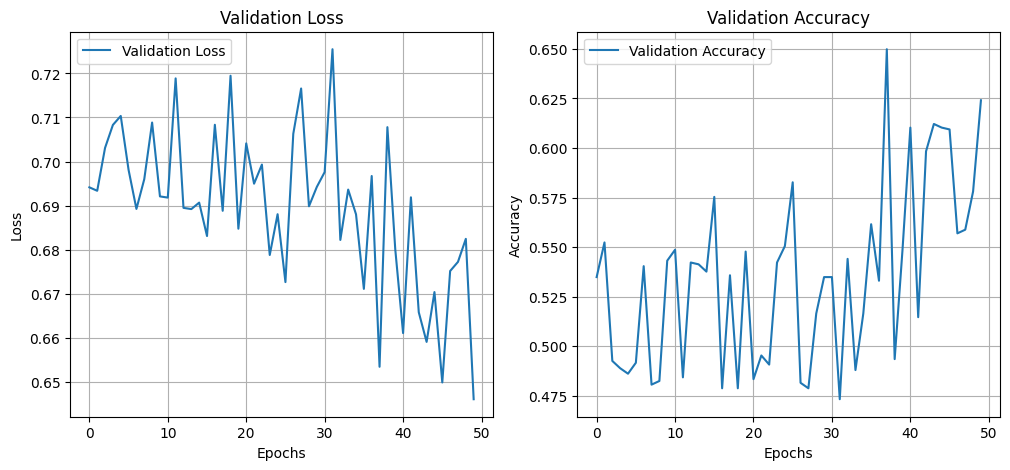

In [45]:
# print max accuracy
max_val_acc = max(val_accs)
print(f"Max Validation Accuracy: {max_val_acc:.4f}")
# Plotting the loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(val_losses, label='Validation Loss')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()